# Binomial Distribution

$$\binom{n}{k} p^k (1-p)^{n-k}$$

> When spun on edge 250 times, a Belgian one-euro coin came up heads 140 times and tails 110. `It looks very suspicious to me,’ said Barry Blight, a statistics lecturer at the London School of Economics. `If the coin were unbiased, the chance of getting a result as extreme as that would be less than 7%.’

“But [MacKay asks] do these data give evidence that the coin is biased rather than fair?”

$\binom{n}{k}$ is the binomial coefficient - "n choose k"

In [1]:
from empiricaldist import Pmf
from scipy.stats import binom
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# If we flip one coin n=2 times and p(heads) is .5, what's the probability of getting k=1 heads?
n = 2
p = 0.5
k = 1
binom.pmf(k, n, p)

0.5000000000000002

In [3]:
# Set up an array of k values
ks = np.arange(n + 1)

# setup probabilities
ps = binom.pmf(ks, n, p)

# On 2 flips
# p(0 heads), p(1 head), p(2 heads)
ps

array([0.25, 0.5 , 0.25])

In [4]:
pmf_k = Pmf(ps, ks)
pmf_k

,probs
0,0.25
1,0.50
2,0.25


In [5]:
# This function computes the binomial distribution
# for given values of n and p 
# and returns a Pmf that represents the result.

def make_binomial(n, p):
    """Make a binomial Pmf"""
    ks = np.arange(n + 1)
    ps = binom.pmf(ks, n, p)
    return Pmf(ps, ks)

In [6]:
pmf_k = make_binomial(n=250, p=0.5)
pmf_k.head()

,probs
0,5.527148e-76
1,1.381787e-73
2,1.720325e-71


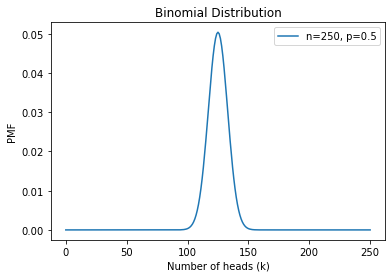

In [7]:
plt.title("Binomial Distribution")
plt.ylabel("PMF")
plt.xlabel("Number of heads (k)")
plt.plot(pmf_k, label="n=250, p=0.5");
plt.legend();

In [8]:
pmf_k.max_prob()

125

In [9]:
# p(exactkly 125 heads)
# pmf_k[125] different api, same results
pmf_k(125)

0.050412213147309655

In [10]:
pmf_k(140)

0.008357181724918204

In [11]:
# Out of 250 flips
# If we have a fair coin, what are the odds of flipping 140 heads?
n = 250
p = 0.5
k = 140
binom.pmf(k, n, p)

0.008357181724918204

> In the article MacKay quotes, the statistician says, “If the coin were unbiased the chance of getting a result as extreme as that would be less than 7%.”



In [12]:
# We'll use the binomial distribution to check MacKay's math. 
# The following function takes a PMF and computes the total probability of quantities greater than or equal to threshold.

def prob_ge(pmf, threshold):
    """Probability of quantities greater than threshold"""
    ge = pmf.qs >= threshold
    total = pmf[ge].sum()
    return total

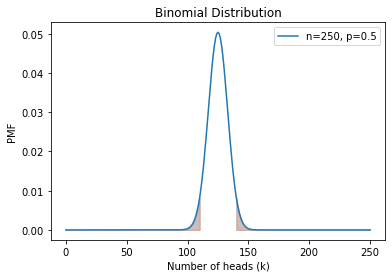

In [13]:
def fill_below(pmf):
    qs = pmf.index
    ps = pmf.values
    plt.fill_between(qs, ps, 0, color='C5', alpha=0.4)

qs = pmf_k.index


fill_below(pmf_k[qs>=140])
fill_below(pmf_k[qs<=110])

pmf_k.plot(label='n=250, p=0.5')

plt.title("Binomial Distribution");
plt.ylabel("PMF")
plt.xlabel("Number of heads (k)")
plt.legend();

In [14]:
prob_ge(pmf_k, 140)

0.03321057562002163

In [15]:
pmf_k.prob_ge(140)

0.03321057562002163

# Bayesian Estimation
> Any given coin has some probability of landing heads up when spun on edge; I’ll call this probability x. It seems reasonable to believe that x depends on physical characteristics of the coin, like the distribution of weight. If a coin is perfectly balanced, we expect x to be close to 50%, but for a lopsided coin, x might be substantially different. We can use Bayes’s theorem and the observed data to estimate x.

**Estimate unknown probabilities!**

In [21]:
# For simplicity we start with a uniform prior (dig into this later)
# Uniform prior is rectangular, assuming all values of x are equally likely
# Here's an implementation of a uniform prior

# equal likelihoods of flipping 0% to 100% heads
hypos = np.linspace(0, 1, 101)
prior = Pmf(1, hypos)
prior.head()

,probs
0.00,1
0.01,1
0.02,1


In [22]:
likelihood_heads = hypos
likelihood_tails = 1 - hypos

In [23]:
likelihood = {
    "H": likelihood_heads,
    "T": likelihood_tails
}

In [45]:
# Let's represent the data as a string
dataset = "H" * 140 + "T" * 110
dataset[0:5]
len(dataset)

250

In [46]:
# The following function does the update.

def update_euro(pmf, dataset):
    """Update pmf with a given sequence of H and T."""
    for data in dataset:
        pmf *= likelihood[data]

    pmf.normalize()

In [47]:
posterior = prior.copy()

In [54]:
update_euro(posterior, dataset)

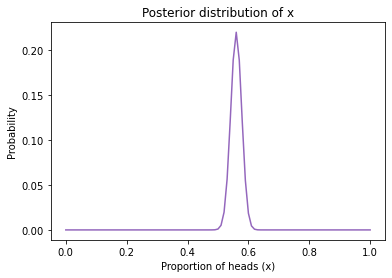

In [55]:
posterior.plot(label="140 heads out of 250", color="C4")
plt.xlabel("Proportion of heads (x)")
plt.ylabel("Probability")
plt.title("Posterior distribution of x")
plt.show();

In [56]:
# If we get 140 heads out of 250
# we can estimate that the p(heads) is 56%
# (and assume uniform uncertainty)
# The 
posterior.max_prob()

0.56

## Triangle Prior

![triangle man](triangleman.jpeg)

In [59]:
# So far we’ve been using a uniform prior:

uniform = Pmf(1, hypos, name='uniform')
uniform.normalize()

101

It might be more reasonable to choose a prior that gives higher probability to values of x near 0.5 and lower probability to extreme values.

In [64]:
ramp_up = np.arange(50) # np.arange(0, 50, 1)
ramp_down = np.arange(50, -1, -1)
a = np.append(ramp_up, ramp_down)

triangle = Pmf(a, hypos, name="triangle")
triangle.normalize()

2500

Text(0, 0.5, 'Probability of heads')

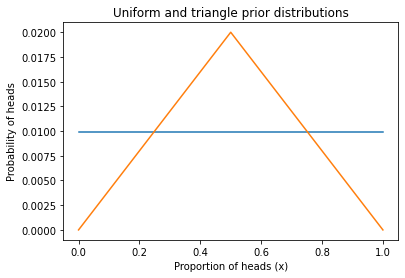

In [69]:
uniform.plot();
triangle.plot();
plt.title("Uniform and triangle prior distributions");
plt.xlabel("Proportion of heads (x)")
plt.ylabel("Probability of heads")

In [70]:
update_euro(uniform, dataset)
update_euro(triangle, dataset)

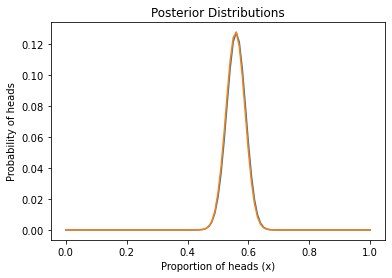

In [74]:
# Plot the updated priors
# The differences between the posterior distributions are barely visible, and so small they would hardly matter in practice.

uniform.plot()
triangle.plot()

plt.xlabel("Proportion of heads (x)")
plt.ylabel("Probability of heads")
plt.title("Posterior Distributions");

The differences between the posterior distributions are barely visible, and so small they would hardly matter in practice.

And that’s good news. To see why, imagine two people who disagree angrily about which prior is better, uniform or triangle. Each of them has reasons for their preference, but neither of them can persuade the other to change their mind.

But suppose they agree to use the data to update their beliefs. When they compare their posterior distributions, they find that there is almost nothing left to argue about.

This is an example of swamping the priors: with enough data, people who start with different priors will tend to converge on the same posterior distribution.

**Ultimately, updating our beliefs with data matters more than our priors**

$$\binom{n}{k} p^k (1-p)^{n-k}$$

In [75]:
from scipy.stats import binom

def update_binomial(pmf, data):
    """Update pmf using the binomial distribution."""
    k, n = data
    xs = pmf.qs
    likelihood = binom.pmf(k, n, xs)
    pmf *= likelihood
    pmf.normalize()

In [76]:
# The data are represented with a tuple of values for k and n, rather than a long string of outcomes. Here’s the update.
uniform2 = Pmf(1, hypos, name="uniform2")
data = 140, 250
update_binomial(uniform2, data)

In [77]:
np.allclose(uniform, uniform2)

True

The 101 Bowls and Euro problem are very similar. 
- The prior distributions are the same. 
- The prior likelihoods are the same
- And w/ the same data, the results would be the same
- But there's more to it

The 101 Bowls problem contained a uniform distribution in the setup, so that make sense.

With the Euro problem, the choice of priors is subjective.

And because the priors are subjective, the posteriors are subjective, too. And some people find that problematic.

In the 101 Bowls problem, we choose the bowl randomly, so it is uncontroversial to compute the probability of choosing each bowl. In the Euro problem, the proportion of heads is a physical property of a given coin. Under some interpretations of probability, that’s a problem because physical properties are not considered random.

Under the Bayesian interpretation of probability, it is meaningful and useful to treat physical quantities as if they were random and compute probabilities about them.

In the Euro problem, the prior distribution represents what we believe about coins in general and the posterior distribution represents what we believe about a particular coin after seeing the data. So we can use the posterior distribution to compute probabilities about the coin and its proportion of heads.

The subjectivity of the prior and the interpretation of the posterior are key differences between using Bayes’s Theorem and doing Bayesian statistics.



## Exercise

In Major League Baseball, most players have a batting average between .200 and .330, which means that their probability of getting a hit is between 0.2 and 0.33.

Suppose a player appearing in their first game gets 3 hits out of 3 attempts. What is the posterior distribution for their probability of getting a hit?

For this exercise, I’ll construct the prior distribution by starting with a uniform distribution and updating it with imaginary data until it has a shape that reflects my background knowledge of batting averages.

In [83]:
# Here's the uniform prior
# I imagine the range of .1 to .4 is to create a bounds for the .2 to .33 likelihoods
hypos = np.linspace(0.1, 0.4, 101)
prior = Pmf(1, hypos)

In [84]:
likelihood = {
    "Y": hypos,
    "N": 1 - hypos
}

In [87]:
# Here’s a dataset that yields a reasonable prior distribution.
# I'm not in love with this approach (yet)
# This sets up someone batting 0.25
# I'm not sure where this batting 0.25 came from since it's not in the problem setup
dataset = "Y" * 25 + "N" * 75

In [89]:
# Update the uniform prior with the data
for data in dataset:
    prior *= likelihood[data]

prior.normalize()

1.3596964206970507e-23

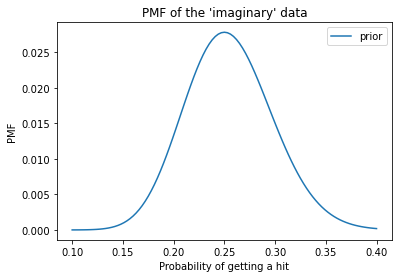

In [95]:
prior.plot(label='prior')
plt.title("PMF of the 'imaginary' data")
plt.xlabel("Probability of getting a hit")
plt.ylabel("PMF")
plt.legend();

*Thought* Since we "proved" that priors don't matter as much as the data we use to update our beliefs, then this batting 0.25 assumption makes a bit more sense.

This does feel arbitrary, however.

In [96]:
# Now update the distribution with the data and plot the posterior. What is the most likely quantity in the posterior distribution?

# Solution

posterior = prior.copy()

for data in 'YYY':
    posterior *= likelihood[data]

posterior.normalize()

0.017944179687707326

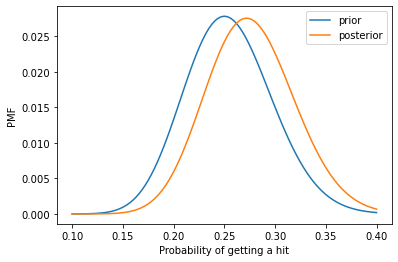

In [102]:
# Solution
prior.plot(label="prior")
posterior.plot(label="posterior")
plt.xlabel("Probability of getting a hit")
plt.ylabel("PMF")
plt.legend();

In [103]:
prior.max_prob(), posterior.max_prob()

(0.25, 0.271)

In [112]:
# But what about updating the priors with hitting 20 balls in a row?
posterior = prior.copy()

for data in 'Y' * 20:
    posterior *= likelihood[data]

posterior.normalize()

6.42403528326428e-11

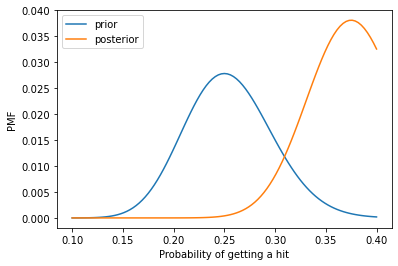

In [113]:
# Solution
prior.plot(label="prior")
posterior.plot(label="posterior")
plt.xlabel("Probability of getting a hit")
plt.ylabel("PMF")
plt.legend();

In [107]:
prior.max_prob(), posterior.max_prob()

(0.25, 0.31900000000000006)

Takeaways:
- If someone hits 20 balls in a row, they highest likelihood for that outcome is if they batted .319?
- Is that what that signifies?
- Since this is about probability simulation using new data, that seems to track. 